# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on predicting the number of air passengers

<i> Hugo Vallet (Telecom Paristech/M2 "Data science" Paris saclay) </i>


# Introduction

The data set was donated by an unnamed company handling flight ticket reservations. The data is thin, it contains :

- the date of departure
- the departure airport
- the arrival airport
- the mean and standard deviation of the number of weeks of the reservations made before the departure date
- a field called log_PAX which is related to the number of passengers (the actual number were changed for privacy reasons)

The goal is to predict the log_PAX column. The prediction quality is measured by RMSE. The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. The challenge in this RAMP is to find good data that can be correlated to flight traffic.

<b>To make this report as readable as possible, I gathered all my preprocessing/postprocessing/vizualisation functions in 3 seperated scripts.<p style="color:red"> If you need to re-run this notebook you should include in your directory these 3 scripts as well as the additional datasets ! </p style="color:red"></b>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()

# 1/Understanding the data
In this challenge, we have 2 training datasets :
- public_train.csv containing approx 11k examples. I used this set for my "everyday training" because, thanks to its limited size, I could train quite fast every model I wnated.
- train.csv contains approx 55k examples. This set is of a size comparable to the one on the RAMP platform. I used it to test my models a last time before submitting to have a quite precise approximation of the score I could achieve on the plateform. 

The 2 datasets are of similar quality, the only real difference between them is the number of training examples. Empirically, I've noticed that a RMSE of approx 0.37 on "public_train" leads to a RMSE of approx 0.27 on "train".

In [2]:
data = pd.read_csv("public_train.csv")
print "Airports listing : ", data['Departure'].unique()

Airports listing :  ['DFW' 'LAX' 'ORD' 'DEN' 'MCO' 'IAH' 'MIA' 'ATL' 'LGA' 'SEA' 'PHX' 'CLT'
 'DTW' 'LAS' 'EWR' 'MSP' 'BOS' 'PHL' 'SFO' 'JFK']


Above, the names of the airports using the IATA code. This codes are the airports' unique international identifier. This information will latter be used to join additional data.

Appart from this info and the info already given to us in the "starting_kit" I was interested in checking if the average log_PAX value depends of the air route.

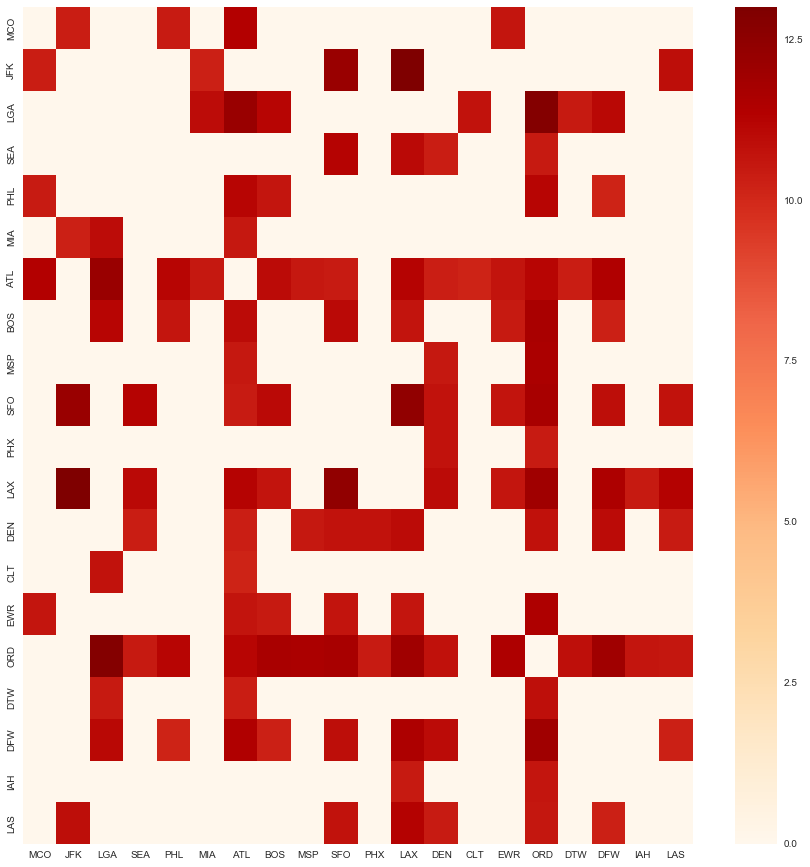

In [3]:
from visualization import airport_log_flow
airport_log_flow(data)

As you can see, there no abnormal log_PAX mean value per air route : the value is quite constantly around 10.0 on every route. We can also check with this adjacency map that not every airports are communicating. This information will latter be used when training multi-models (part 6).

# 2/Training the first models
First, I retreat the data in the way proposed by the starting kit.

In [6]:
from preprocessing import dummy_converter
data_converted = dummy_converter(data)
X_array = data_converted.drop(['log_PAX','DateOfDeparture'], axis=1).values
X_columns = data_converted.columns.drop(['log_PAX','DateOfDeparture'])
y_array = data_converted['log_PAX'].values

Let's cut our data between a train and a test split.

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=0)
#Note : we will always force the random_state at 0 to make models comparable


from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

reg = RandomForestRegressor(n_estimators = 120,max_depth =90, max_features = "auto")
scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error')
print("Random forest RMSE: {:.4f} +/-{:.4f}".format(np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

Random forest RMSE: 0.4563 +/-0.0194


We see that, just allowing the random forest to have more estimators, a greater depth and as features as wanted allows our forest to have a clearly improved cross-validated error than in the starting kit. We can check at the features importances in the forest :

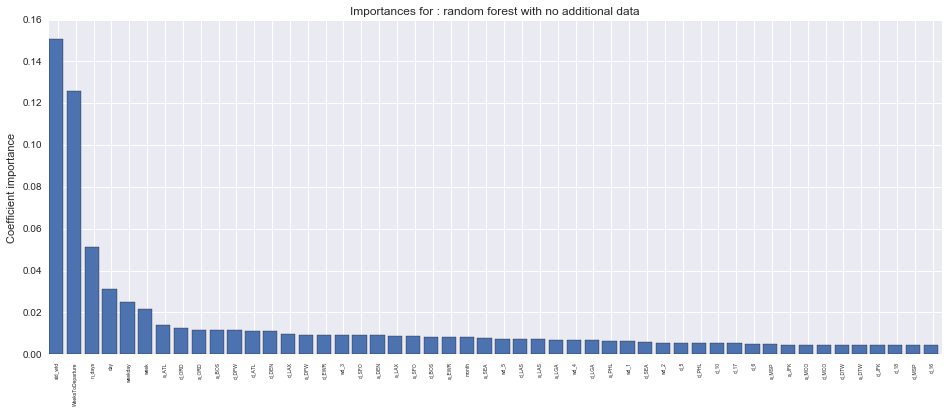

In [41]:
from visualization import plot_coeff_importances
reg.fit(X_train,y_train)
fig, ax = plt.subplots(1,1,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax, title = " random forest with no additional data")

Here, we see that, in fact, apart from some added features like the week, the day, or the weeks to departure, the others have all small, and almost equal, importances. 

# 3/Optimizing a gradient boosted regressor

Gradient boosting is a classical machine learning technique. Like random forests it can deal with non-homogeneous data. In this challenge, this caracteristic seemed important to me because, latter, we will add new features containing, possibly, very different types of variables. Moreover, this models are quite understandable as far as they are, like random forests, based on the aggregation of trees. 
The main advantage of gradient boosting over random forests is a greater number of parameters allowing us, in theory, to tune more precisely the model, at an additional computational cost.

Let's make a first try :

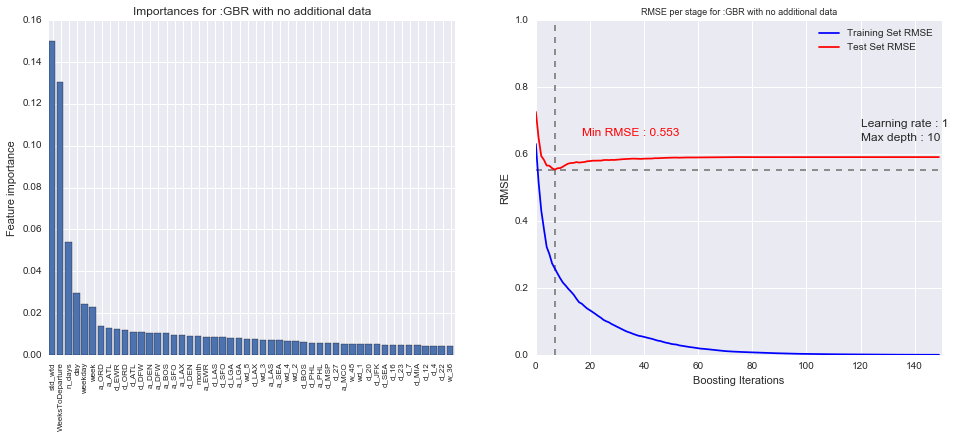

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from visualization import plot_stages
from visualization import plot_coeff_importances
params = {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 3,'learning_rate': 1, 'loss': 'ls', 'max_features' : "auto"}
reg = GradientBoostingRegressor(**params)
reg.fit(X_train,y_train)
reg.name = "GBR with no additional data"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax[0], title = reg.name)
plot_stages(reg,X_train,y_train,X_test,y_test,ax[1], title = reg.name)

<b> Interpretation of the results :</b>
- Graph on the left : we have here the features' imoortances, as with the random forest. First, we see that the most important features here the ones added by the dummy converter. We see a quite clear ordering in the importances : first the "general features" and then the airports boolean features. Compared to random forest, this ordering is really emphasized.
- Graph on the right : here we follow the train/test RMSE at each iteration of the boosting algorithm using the function "staged_predict" provided by sklearn. We see a clear overfitting tendency appearing quickly : approximately at the 10th iteration. We have to tune our parameters : this will be done by brutal grid searching.

<i>Note: The GBR class of sklearn will automatically select the best performing boosted model along the iterations. This give us a pretty nice automatic control over overfitting.</i>

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error,make_scorer

scorer = make_scorer(mean_squared_error)
param_grid = [{
  'n_estimators' : [200], 
  'max_depth': [3,5,7,10], 
  'min_samples_leaf':[1,3,6],
  'learning_rate':[0.1,0.5,1],
  'loss':['ls'],
  'max_features':['auto','sqrt']}]
reg = GradientBoostingRegressor()
best_reg = GridSearchCV(reg, param_grid, scoring = scorer)
best_reg.fit(X_train,y_train)
best_reg.predict(X_test)
print "RMSE :", np.sqrt(best_reg.best_score_)

Grid searching is very long (we do a 3-fold cross validation for each set of parameters !). But finally, I came to the following conclusions :
- The lower the learning rate/the larger number of trees, the better.
- We must force the algo to have a minimum number of samples per leaf, min = 3 give good results.
- We must make quite deep trees, max_depth = 10 is not bad.

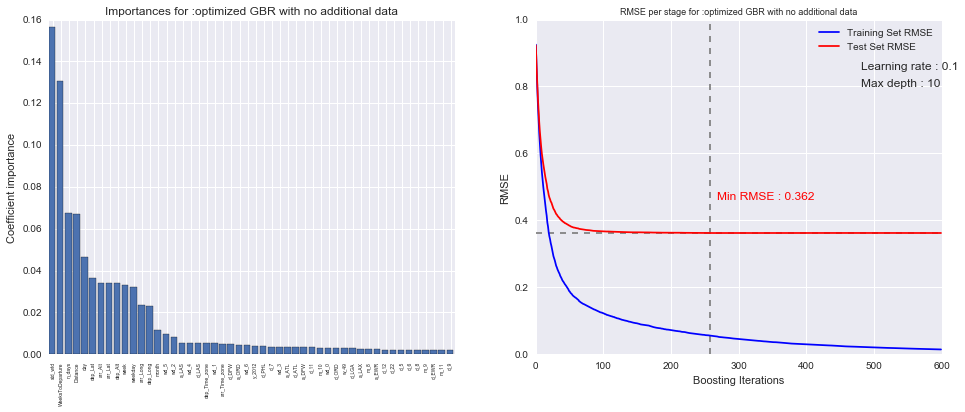

In [58]:
best_params={'loss': 'ls', 'learning_rate': 0.1, 'min_samples_leaf': 3, 'n_estimators': 600, 'max_features': 'auto','max_depth': 10}
reg = GradientBoostingRegressor(**best_params)
reg.fit(X_train,y_train)
reg.name = "optimized GBR with no additional data"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax[0], title = reg.name)
plot_stages(reg,X_train,y_train,X_test,y_test,ax[1], title = reg.name)

No more real overfitting tendency as we use a very small step size.
We are beating the random forest !

# 4/Joining additional data

This is the part where I concentrated most of my efforts.


<b> Adding meteorological data </b>

First, we can use the meteorological data given to us. This data contains 2 columns with nan values ("max gust speed km/h" and  "precipitation") and a column "Events" with strings. So, before joining the data we have to fix that. 
- For the "Events" column I used the following procedure : when there was no value, I assumed that this was because there was no special weather like "snow", "thunderstorm", or "rain". So, when I saw a missing value, I chacked on the "Cloud cover" column : if the cover was < 4 I put "Sunny" in the event column, otherwise I put "Cloudy". At that step I had a column full of events indicators with no missing values. I coded these events on integers values, grouping some kind of events. For example I grouped all events containing "thunderstorm" in a category with value 0 indicating an extrem weather. I also grouped all the events with "snow" together, etc. This gave me homogenous classes of enough importany size (> 100 examples).
- For the max gust speed, I assumed that missing values were indicating no gust. So for these values I just put the max wind speed.
- Precipitation column was containing strange values and beacuse I had already an "Event" column indicating rain, I brutally dropped the column.


The functions used for fixing the meteo data can be found in my preprocessing script (they are implicitely called when aggregating the meteo data) :
- fix_gust_speed
- fix_events_column

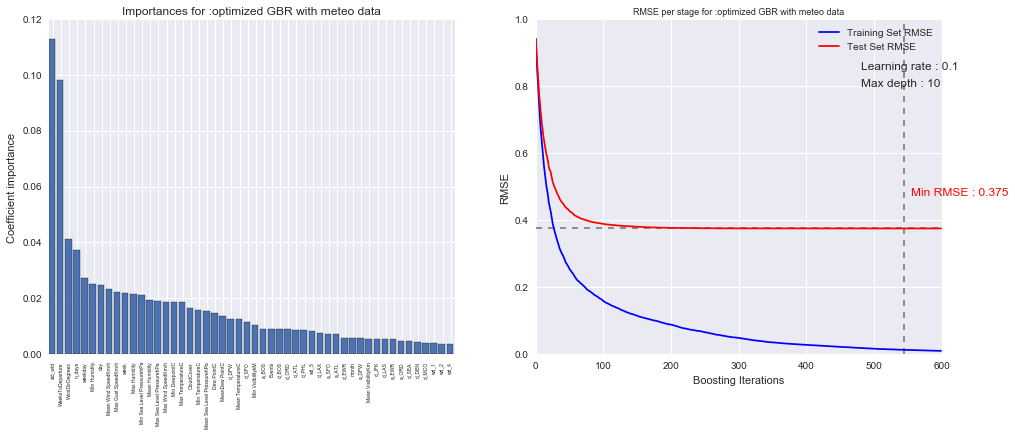

In [52]:
from preprocessing import meteorological_data
data_completed = meteorological_data(data)
data_converted = dummy_converter(data_completed)
X_array = data_converted.drop(['log_PAX','DateOfDeparture'], axis=1).values
X_columns = data_converted.columns.drop(['log_PAX','DateOfDeparture'])
y_array = data_converted['log_PAX'].values

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=0) #Use the same split as before

reg.fit(X_train,y_train)
reg.name = "optimized GBR with meteo data"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax[0], title = reg.name)
plot_stages(reg,X_train,y_train,X_test,y_test,ax[1], title = reg.name)

We clearly see that the new features are considered important by the algorithm but they don't add a real discriminative information compared to the previous features. The curve on the right must be taken with prudence as the error displayed had not been cross validated. In fact we don't have a real improvement in term of precision compared to the no additional data method, our scores are even worse.

<b> Adding geographical data </b>

My second idea was to link the airports (all huge US airports) with their geographical data. In particular, I thought that, maybe, the number of passengers per flight could be correlated with the distance between the arrival and the departure. So I gathered additional data to test that idea. 

From the site http://openflights.org/data.html I downloaded the GPS position and altitude of every airport on Earth. I then linked this data set with my initial data using the IATA codes of the airports.

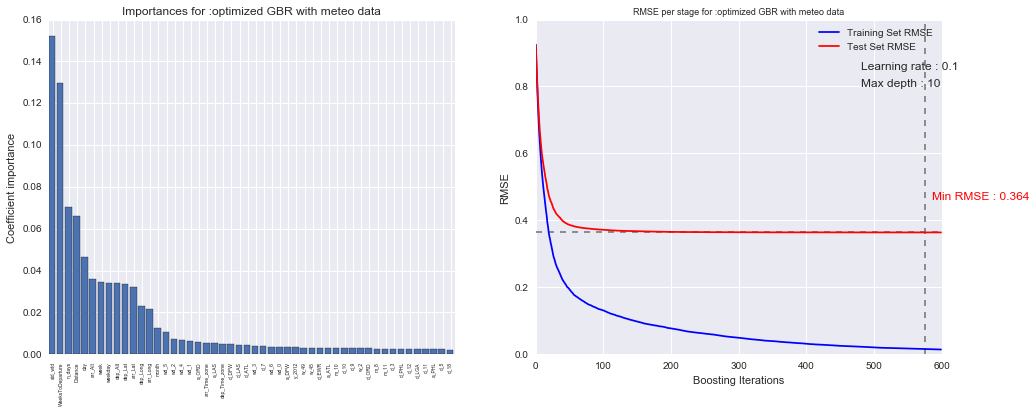

In [59]:
from preprocessing import airport_geographic_data

data_completed = airport_geographic_data(data)
data_converted = dummy_converter(data_completed)
X_array = data_converted.drop(['log_PAX','DateOfDeparture'], axis=1).values
X_columns = data_converted.columns.drop(['log_PAX','DateOfDeparture'])
y_array = data_converted['log_PAX'].values

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=0) #Use the same split as before

reg.fit(X_train,y_train)
reg.name = "optimized GBR with geo data"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax[0], title = reg.name)
plot_stages(reg,X_train,y_train,X_test,y_test,ax[1], title = reg.name)

The distance seems to be a strong feature in that case. The other features, of lower importance, could contribute to noise the set, that's why, in my final method I also assessed the performances keeping only the distance (and dropping the GPS position and altitude)

<b> Adding aircraft accidents data </b>

A classical idea could also be to think that the air passenger traffic is correlated to the number of aircrafts accidents in the US. I found an interesting data set on that topic on the website of the Airlines and Airports | Bureau of Transportation Statistics http://www.rita.dot.gov/bts/sites. The dataset includes the total fatalities year-by-year, so I brutally linked it with the flights years.

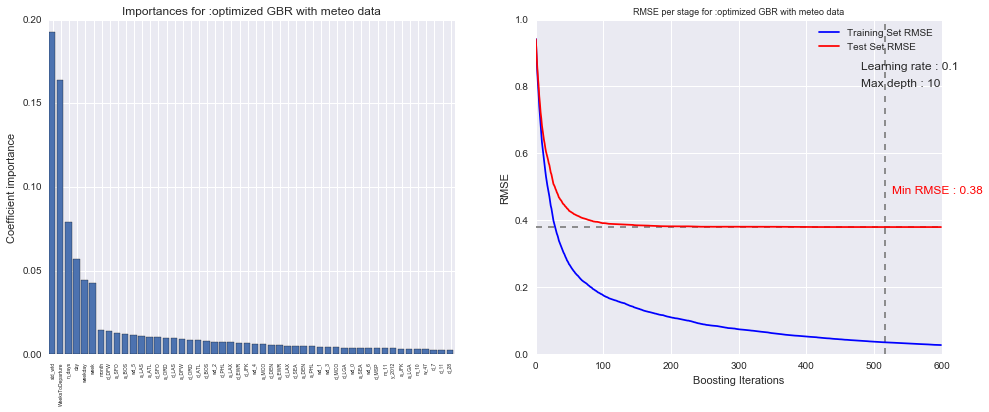

In [60]:
from preprocessing import air_accidents_data

data_completed = air_accidents_data(data)
data_converted = dummy_converter(data_completed)
X_array = data_converted.drop(['log_PAX','DateOfDeparture'], axis=1).values
X_columns = data_converted.columns.drop(['log_PAX','DateOfDeparture'])
y_array = data_converted['log_PAX'].values

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=0) #Use the same split as before

reg.fit(X_train,y_train)
reg.name = "optimized GBR with accidents data"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax[0], title = reg.name)
plot_stages(reg,X_train,y_train,X_test,y_test,ax[1], title = reg.name)

<b> Final idea implemented : adding the total number of passengers who transited in the airports each months </b>

Basically, we can also imagine that our number of passenger per flight is a function of the total number of passenger transiting by the airport : some "hub" airports are used a intermediate destination, if we have a huge number of passengers transitting in these airports, then the aircompanies will tend to optimize the flights to fill the aircrafts at maximum capacity.

I found a complete free dataset on http://www.anna.aero/databases/ describing the total number of passengers who transited per US airports per month during the years 2011/2013. I linked this new data set with the initial one on the month, the year and the airports' IATA codes. I made this process for both the departure point and the arrival point. 

preprocessing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  column['year']=int(year)
preprocessing.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  column['month']=int(month)


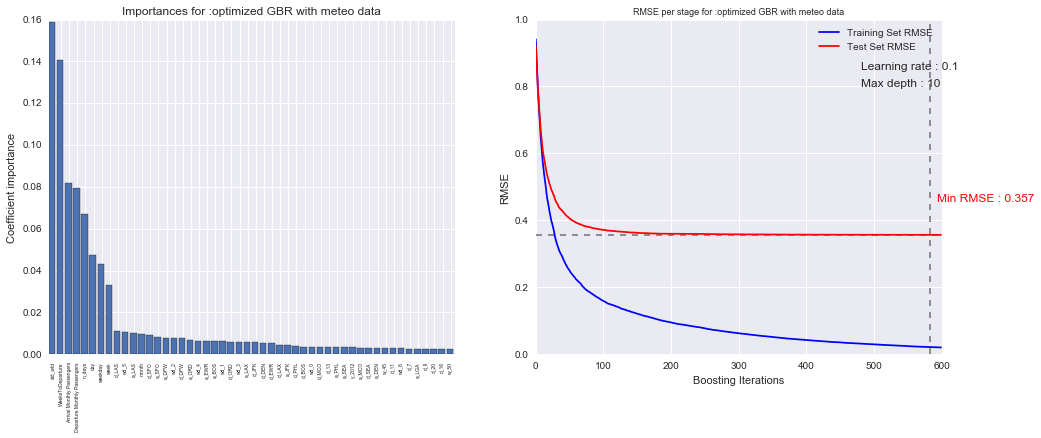

In [61]:
from preprocessing import airports_monthly_traffic

data_completed = airports_monthly_traffic(data)
data_converted = dummy_converter(data_completed)
X_array = data_converted.drop(['log_PAX','DateOfDeparture'], axis=1).values
X_columns = data_converted.columns.drop(['log_PAX','DateOfDeparture'])
y_array = data_converted['log_PAX'].values

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=0) #Use the same split as before

reg.fit(X_train,y_train)
reg.name = "optimized GBR with monthly traffic data"
fig, ax = plt.subplots(1,2,figsize=(16,6))
plot_coeff_importances(reg, X_columns, ax[0], title = reg.name)
plot_stages(reg,X_train,y_train,X_test,y_test,ax[1], title = reg.name)

Even though the RMSE is not cross-validated we see that we have made, here, a real (small) progress. The arrival and departure monthly passengers are our 3rd and 4th more important features here. This confirms that the choice of that features was quite relevant.

<b> Testing combinations of additional features </b>

Finally I made multiple set combining all the features previously mentionned and assess the performances.

In [78]:
data = pd.read_csv("train.csv")
#Initial input : no added features, just dummy conversion
data_converted0 = dummy_converter(data)
X0 = data_converted0.drop(['log_PAX','DateOfDeparture'], axis=1).values
X0 = scale(X0)
X0_columns = data_converted0.columns.drop(['log_PAX','DateOfDeparture'])
y0 = data_converted0['log_PAX'].values

#First input : added all geographical features
data_completed1 = airport_geographic_data(data)
data_converted1 = dummy_converter(data_completed1)
X1 = data_converted1.drop(['log_PAX','DateOfDeparture'], axis=1).values
#X1 = scale(X1)
X1_columns = data_converted1.columns.drop(['log_PAX','DateOfDeparture'])
y1 = data_converted1['log_PAX'].values

#second input : added just geographical distance btw airports
data_completed2 = airport_geographic_data(data, include_names=False,keep_only_distance=True,scaling=False)#Added a scaling parameter for scaling the distances added
data_converted2 = dummy_converter(data_completed2)
X2 = data_converted2.drop(['log_PAX','DateOfDeparture'], axis=1).values
X2_columns = data_converted2.columns.drop(['log_PAX','DateOfDeparture'])
y2 = data_converted2['log_PAX'].values

#Third input : added nan-fixed meteorological features
data_completed3 = meteorological_data(data)
data_converted3 = dummy_converter(data_completed3)
X3 = data_converted3.drop(['log_PAX','DateOfDeparture'], axis=1).values
X3_columns = data_converted3.columns.drop(['log_PAX','DateOfDeparture'])
y3 = data_converted3['log_PAX'].values

#Fourth input : added number of aircrafts accidents in the US
data_completed4 = air_accidents_data(data)
data_converted4 = dummy_converter(data_completed4)
X4 = data_converted4.drop(['log_PAX','DateOfDeparture'], axis=1).values
X4_columns = data_converted4.columns.drop(['log_PAX','DateOfDeparture'])
y4 = data_converted4['log_PAX'].values

#Fifth input : added the total number of passenger per airport per year
data_completed5 = airports_traffic(data)
data_converted5 = dummy_converter(data_completed5)
X5 = data_converted5.drop(['log_PAX','DateOfDeparture'], axis=1).values
X5_columns = data_converted5.columns.drop(['log_PAX','DateOfDeparture'])
y5 = data_converted5['log_PAX'].values

#Sixth input : added the total number of passenger per airport per month
data_completed6 = airports_monthly_traffic(data)
data_converted6 = dummy_converter(data_completed6)
X6 = data_converted6.drop(['log_PAX','DateOfDeparture'], axis=1).values
X6_columns = data_converted6.columns.drop(['log_PAX','DateOfDeparture'])
y6 = data_converted6['log_PAX'].values

params = {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 3,'learning_rate': 0.1, 'loss': 'ls', 'max_features' : "auto"}
reg0 = GradientBoostingRegressor(**params)
reg0.name="GBR with no additional data"
reg1 = GradientBoostingRegressor(**params)
reg1.name="GBR with all geographical data"
reg2 = GradientBoostingRegressor(**params)
reg2.name="GBR with airport distance data"
reg3 = GradientBoostingRegressor(**params)
reg3.name="GBR with meteo data"
reg4 = GradientBoostingRegressor(**params)
reg4.name="GBR with accidents data"
reg5 = GradientBoostingRegressor(**params)
reg5.name="GBR with year flux"
reg6 = GradientBoostingRegressor(**params)
reg6.name="GBR with month flux"

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2,random_state=0)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,random_state=0)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2,random_state=0)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2,random_state=0)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2,random_state=0)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2,random_state=0)

reg0.fit(X0_train, y0_train)
reg1.fit(X1_train, y1_train)
reg2.fit(X2_train, y2_train)
reg3.fit(X3_train, y3_train)
reg4.fit(X4_train, y4_train)
reg5.fit(X5_train, y5_train)
reg6.fit(X6_train, y6_train)

y0_pred = reg0.predict(X0_test)
y1_pred = reg1.predict(X1_test)
y2_pred = reg2.predict(X2_test)
y3_pred = reg3.predict(X3_test)
y4_pred = reg4.predict(X4_test)
y5_pred = reg5.predict(X5_test)
y6_pred = reg6.predict(X6_test)

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
plot_stages(reg0, X0_train, y0_train, X0_test, y0_test, axes[0,0],title=reg0.name)
plot_stages(reg1, X1_train, y1_train, X1_test, y1_test, axes[0,1],title=reg1.name)
plot_stages(reg2, X2_train, y2_train, X2_test, y2_test, axes[0,2],title=reg2.name)
plot_stages(reg3, X3_train, y3_train, X3_test, y3_test, axes[1,0],title=reg3.name)
plot_stages(reg4, X4_train, y4_train, X4_test, y4_test, axes[1,1],title=reg4.name)
plot_stages(reg5, X5_train, y5_train, X5_test, y5_test, axes[1,2],title=reg5.name)
plot_stages(reg6, X6_train, y6_train, X6_test, y6_test, axes[2,1],title=reg6.name)

Let's make a conbined data set with the best features !

In [76]:
data_completed_all = airports_traffic(data)
data_completed_all = airport_geographic_data(data_completed_all, include_names=False,keep_only_distance=True)
data_completed_all = airports_monthly_traffic(data_completed_all)
data_completed_all = air_accidents_data(data_completed_all)
data_converted_all = dummy_converter(data_completed_all)
X_array = data_converted_all.drop(['log_PAX','DateOfDeparture'], axis=1).values
X_columns = data_converted_all.columns.drop(['log_PAX','DateOfDeparture'])
y_array = data_converted_all['log_PAX'].values

reg = GradientBoostingRegressor(**best_params)
scores = cross_val_score(reg, X_train, y_train, cv=3, scoring='mean_squared_error')
print("GBR with multiple add data RMSE: {:.4f} +/-{:.4f}".format(np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

GBR with multiple add data RMSE: 0.4124 +/-0.0076


# 5/Aggregating additional features in a table for the RAMP submission

This part was more tricky that it seemed at first view ! To be able to join the initial dataset with a additional data in copied the format of the meteo data table which given to us. that is to say, I generated a new table where each line is a combination of a date (in the range we were given) the departure airport and the arrival airport. This gives us exaclty 220800 combinations possible. Of course, I automated the process :

In [ ]:
#Aggregated_add_data is a table with dates/departures combinations. 
add_data = pd.read_csv("Aggregated_add_data.csv")
names=add_data["Departure"].unique()
columns = ["DateOfDeparture","Departure","Arrival"]
add_data2=pd.DataFrame(columns)

#We add the arrival combinations using a simple for loop
for name in names:
    temp = add_data
    temp["Arrival"]=name
    add_data2=add_data2.append(temp,verify_integrity=False)
    
#Format data
add_data2 = add_data2[columns]
add_data2 = add_data2.iloc[3:,:]
add_data2.index = np.arange(0,220800)

#Include the additional features we want using the functions in "preprocessing.py" ! (here example with 3 additional tables)
data_completed_all = airport_geographic_data(add_data2, include_names=False,keep_only_distance=True,scaling=False)
data_completed_all = airports_traffic(data_completed_all)
data_completed_all = air_accidents_data(data_completed_all)

#Save in a file (Be carefull with the encoding ! With bad encoding date casting could be painful and, thus, can generate errors when merging on dates)
data_completed_all.to_csv("external_data_sub1.csv",sep=",",index=False,encoding='utf-8')

The combination : initial data/distance between airports/monthly passengers per airport/accidents, with the bests params for GBR gave a 0.271 RMSE on the RAMP (2nd submission). This score was coherent with my test score after training on <b>the 55k ex dataset</b>.

# 6/Multi-models

This was my last idea for the RAMP.
The idea is to train 1 model par air route, to check if some progresses can be made individually. The problem is that, even with the 55k dataset, the number of training examples per route is quite low (approx 500 ex per route). To tackle this, I made the - propably false - assumption that the orientation of the route is not relevant. That is to say I considered training my individual models on the examples with ($departure = airport_x,arrival = airport_y$) AND ($departure = airport_y,arrival = airport_x$). Thus, I managed to have approx 1k examples per route. 

In [ ]:
data = pd.read_csv("train.csv") #We take the 55k dataset to be as close as possible of the RAMP scores
data = data.drop("Unnamed: 0",axis=1)
data_completed_all = airports_traffic(data)
data_completed_all = airport_geographic_data(data_completed_all, include_names=False,keep_only_distance=True,scaling=False)
data_completed_all = airports_monthly_traffic(data_completed_all)
data_completed_all = air_accidents_data(data_completed_all)
reg = GradientBoostingRegressor(**best_params)
airports=data["Departure"].unique()

data_train, data_test, y_train, y_test = train_test_split(data_completed_all, data_completed_all["log_PAX"], test_size=0.2)
data_train = dummy_converter(data_train,only_for_date=True)
data_test = dummy_converter(data_test,only_for_date=True)
data_train = data_train.drop(["DateOfDeparture"],axis=1)
data_test = data_test.drop(["DateOfDeparture"],axis=1)

results=np.zeros(len(y_test))
names=[]
it=0

#Iterate on all the departure/arrival combiantions 
for airport1,airport2 in itertools.combinations(airports,2):
    road_train = data_train[(data_train["Departure"]==airport1) ^ (data_train["Departure"]==airport2)]
    road_train = road_train[(road_train["Arrival"]==airport2) ^ (road_train["Arrival"]==airport1)]
    y_road_train = road_train["log_PAX"]
    road_train = road_train.drop(["Departure","Arrival","log_PAX"],axis=1)
    
    road_test = data_test[(data_test["Departure"]==airport1) ^ (data_test["Departure"]==airport2)]
    road_test = road_test[(road_test["Arrival"]==airport2) ^ (road_test["Arrival"]==airport1)]
    y_road_test = road_test["log_PAX"]
    road_test = road_test.drop(["Departure","Arrival","log_PAX"],axis=1)
    
    if road_train.shape[0]!=0: #If the to airports are not communicating make no prediction of course !
        reg.fit(road_train,y_road_train)
        y_road_pred = reg.predict(road_test)
        results[it]=np.sqrt(mean_squared_error(y_road_pred,y_road_test))
        names.append(airport1+airport2)
        it=it+1
        


I have run the cell above 5 times to create "by hand" my cross val score in an excel tab. These are the results :

In [73]:
results = pd.read_csv("results_per_route.csv")
results[results["Xval"]<0.27]

,Route,Result 1,Result 2,Result 3,Result 4,Result 5,Xval
3,DENLAX,0.252585,0.217787,0.287637,0.241022,0.251055,0.250017
5,DENORD,0.228723,0.281662,0.315655,0.265801,0.250379,0.268444
25,LAXATL,0.241692,0.257476,0.236969,0.262773,0.285803,0.256943
27,LAXORD,0.244601,0.215915,0.218370,0.218158,0.235288,0.226467
28,LAXSFO,0.249221,0.238166,0.220311,0.197007,0.217387,0.224419
30,LAXDFW,0.225225,0.261560,0.232177,0.230954,0.261818,0.242347
31,LAXSEA,0.203919,0.221307,0.241988,0.232764,0.198108,0.219617
32,LAXJFK,0.254884,0.275808,0.239418,0.220501,0.272833,0.252689
55,SFOSEA,0.249520,0.257768,0.263882,0.249184,0.229088,0.249888


The routes above have an individual X-val score below the one I got with a global model. This information could be used to improve my performances on the RAMP, I will try to add that part on D-Day !

# 7/Things I tried that didn't work...

A lot of things...

For example : feature selection (not very relevant with boosted methods because, normally, noisy features are not selected to construct the trees and moreover irrelevant trees are weighted low), most of the individuals models above, most of the additional features I made, rbf kernel SVMs,etc. I also spent a lot of time searching for dataset containing the number of operating airlines per airports (a feature I could have used to improve my score), without success... This info doesn't seem publicly available, maybe for commercial reasons.

# Conclusion

This data project made me face some difficulties : gathering and aggregating carefully all the datasets, mainly. I appreciated the "data seeking" part, going on air agencies' websites to find relevant data. I lack of time to work better on the modelization part, I could have made a more complex model, for example trying 7/ before... I also made the choice of the GBR very soon, maybe an ensemble method with adaptative models per air routes could have performed better. 

I have, however, a big regret on this challenge : we didn't know explicitely what the log_PAX variable was. Having a better knowledge of that, as well as a better understanding of the air transport industry could have been a real help, especially when trying to add new meaningful features.